In [47]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.cluster.hierarchy as hcluster
import random

In [61]:
batch1 = pd.read_parquet(r"C:\Users\schei\OneDrive\Desktop\icecube project\batch_1.parquet\batch_1.parquet")
sensor_geom = pd.read_csv(r"C:\Users\schei\OneDrive\Dokumente\GitHub\ice-cube\sensor_geometry.csv")

In [62]:
def id_to_xyz(sen_id):
    return sensor_geom.loc[sen_id][['x','y','z']].values

In [63]:
batch1.head()
event_list=list(set(batch1.index))
event_index=event_list[0]
event=batch1.loc[event_index]

In [64]:
test = event[['sensor_id', 'time', 'charge']].reset_index()

In [65]:
for i in range(0, len(event)):
    test.loc[i,['x','y','z']] = id_to_xyz(test.loc[i,'sensor_id'])

In [107]:
def mydist(a,b):
    diff=a-b
    return np.dot(diff*diff, (np.array([1,1,1,2000])) )


In [108]:
def cluster_by_event(event, threshhold=150):
    trunc_event=event[['sensor_id', 'charge']]
    raw_data = [np.append(id_to_xyz(trunc_event.iloc[i][0]), trunc_event.iloc[i][1]) for i in range(len(trunc_event))]
    clusters = hcluster.fclusterdata(raw_data, threshhold, metric=mydist, criterion='distance')
    return clusters, raw_data

In [109]:
for row in raw_data:
    print(row)

[  -9.68        -79.5        -226.5           0.67500001]
[-526.63        -15.6         162.25          0.57499999]
[-526.63   -15.6    162.25     0.875]
[-324.39        -93.43       -316.86          0.42500001]
[ 576.37   170.92  -339.97     1.375]
[ 237.78       -442.42        297.22          1.47500002]
[-279.53         23.17       -486.4           2.17499995]
[ -43.27       -267.52        312.9           0.97500002]
[-2.7953e+02  2.3170e+01 -4.8640e+02  3.7500e-01]
[ 282.18       -325.74       -454.72          0.67500001]
[-111.51        159.98       -350.5           1.47500002]
[ 237.78       -442.42        212.11          0.67500001]
[  57.2   -105.52  -434.74     1.125]
[ 124.97  -131.25  -289.3      0.625]
[ 106.94    27.09  -399.05     2.625]
[ 114.39       -461.99        -28.98          1.02499998]
[ 114.39       -461.99        -46.            0.72500002]
[ 114.39       -461.99        -46.            0.67500001]
[ 114.39  -461.99   -63.02     1.125]
[ 1.14390000e+02 -4.619900

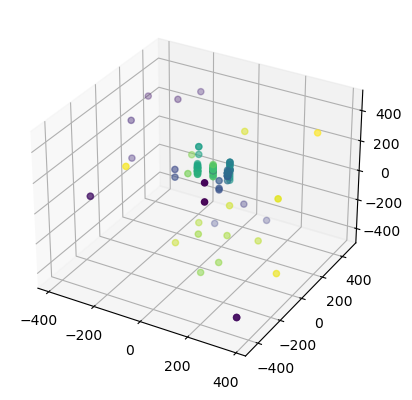

Number of clusters: 68 
 Event_id: 140


In [122]:
#event_id=random.choice(event_list)
event_id=140
event=batch1.loc[2638738]
clusters, raw_data=cluster_by_event(event,150)
    
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = [a[0] for a in raw_data]
ys = [a[1] for a in raw_data]
zs = [a[2] for a in raw_data]

ax.scatter(xs, ys, zs,
           c=clusters)

plt.show()

print("Number of clusters:", len(set(clusters)),'\n Event_id:', event_id )